# 환경설치

In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 필요한 라이브러리 설치 (코랩에서 실행)
!pip install torch torchvision matplotlib seaborn pandas numpy Pillow scikit-learn


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [2]:

# 기본 라이브러리 import
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import os

import matplotlib.font_manager as fm

# 폰트 설정
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# fontprop = fm.FontProperties(fname=font_path, size=10)
# plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['axes.unicode_minus'] = False
# 폰트 설정
font_path='/System/Library/Fonts/AppleGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

# 시드 설정 (재현 가능한 결과를 위해)
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print("MPS 사용 가능:", torch.backends.mps.is_available())
print("MPS 빌드됨:", torch.backends.mps.is_built())

PyTorch 버전: 2.5.1
CUDA 사용 가능: False
MPS 사용 가능: True
MPS 빌드됨: True


 텍스트 분석 파이프라인 초기화
 텍스트 파이프라인 완전 분석 시작
 텍스트 통계 분석 시작...
    short 설정 분석 중...
    medium 설정 분석 중...
    long 설정 분석 중...
 텍스트 분석 그래프 생성...


/var/folders/xn/w4kqb1715fz7h49tp_h7hbmr0000gn/T/ipykernel_82491/3517303356.py:215: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([domain_lengths[domain] for domain in domain_names],


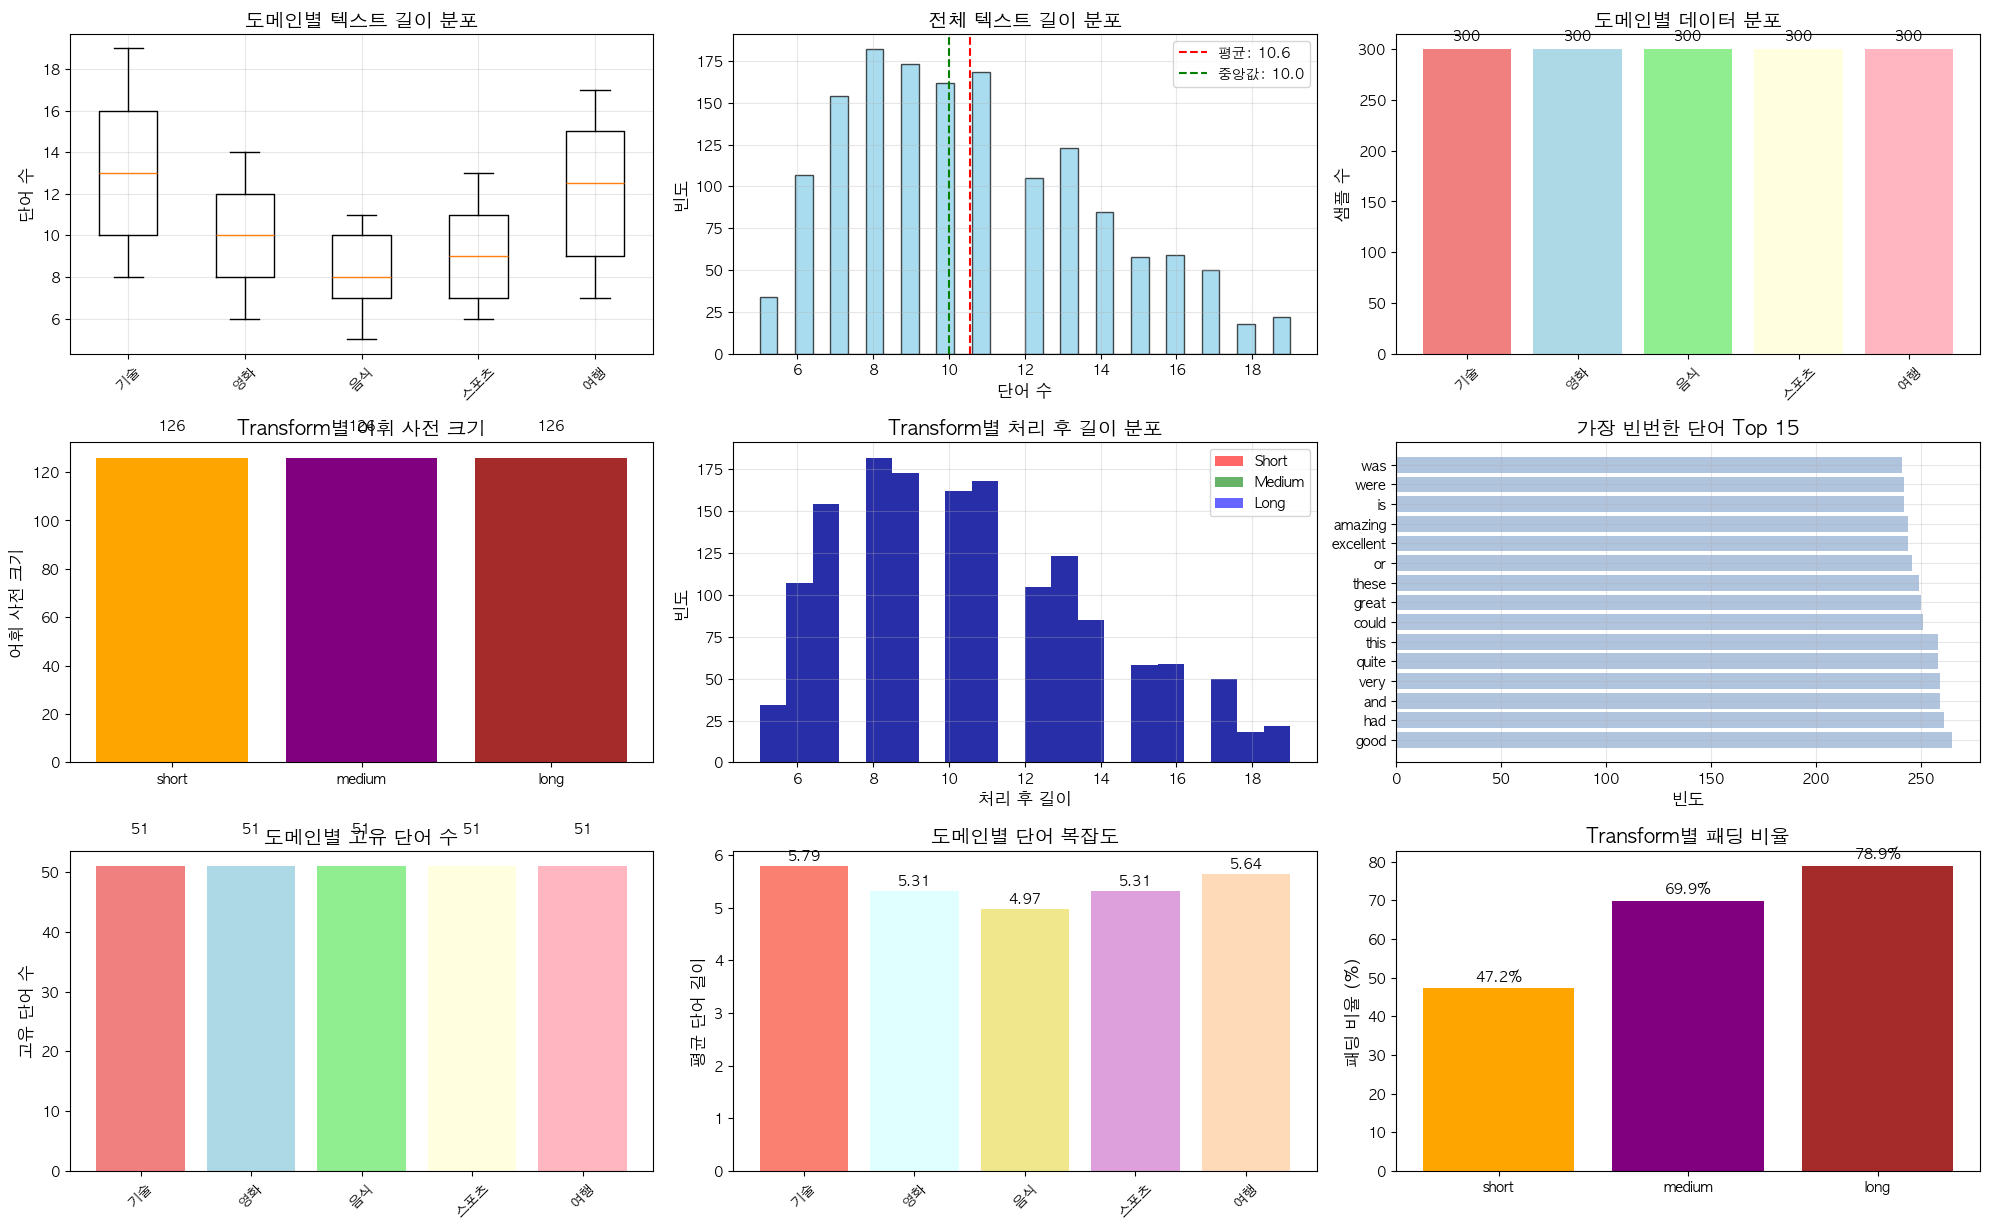


 텍스트 분석 요약:
     도메인 |    샘플수 |     평균길이 |     고유단어 |      단어복잡도
--------------------------------------------------------------------------------
      기술 |    300 |     13.2 |       51 |       5.79
      영화 |    300 |     10.0 |       51 |       5.31
      음식 |    300 |      8.1 |       51 |       4.97
     스포츠 |    300 |      9.3 |       51 |       5.31
      여행 |    300 |     12.2 |       51 |       5.64

 Transform 설정 비교:
------------------------------------------------------------
 Transform |     최대길이 |     어휘크기 |       패딩비율
------------------------------------------------------------
     short |       20 |      126 |      47.2%
    medium |       35 |      126 |      69.9%
      long |       50 |      126 |      78.9%

 텍스트 파이프라인 분석 완료!


In [3]:
from collections import Counter

class TextAnalysisPipeline:
    """텍스트 데이터 파이프라인과 분석을 위한 클래스"""

    def __init__(self):
        print(f" 텍스트 분석 파이프라인 초기화")

    def create_fake_text_dataset(self, num_samples=1000):
        """가상 텍스트 데이터셋 생성 (다양한 도메인)"""

        # 도메인별 단어 집합
        domains = {
            '기술': ['AI', 'machine', 'learning', 'algorithm', 'data', 'neural', 'network', 'deep', 'model', 'training',
                   'computer', 'software', 'programming', 'code', 'development', 'system', 'technology', 'digital'],

            '영화': ['movie', 'film', 'actor', 'director', 'story', 'plot', 'scene', 'character', 'cinema', 'screen',
                   'drama', 'comedy', 'action', 'thriller', 'romance', 'script', 'production', 'award'],

            '음식': ['food', 'restaurant', 'delicious', 'taste', 'flavor', 'cook', 'recipe', 'kitchen', 'meal', 'dish',
                   'ingredient', 'spicy', 'sweet', 'sour', 'fresh', 'menu', 'chef', 'dining'],

            '스포츠': ['game', 'team', 'player', 'score', 'win', 'match', 'sport', 'ball', 'goal', 'championship',
                     'training', 'coach', 'field', 'competition', 'athletic', 'fitness', 'exercise', 'league'],

            '여행': ['travel', 'trip', 'vacation', 'hotel', 'flight', 'destination', 'tourist', 'city', 'country', 'culture',
                   'adventure', 'explore', 'journey', 'sightseeing', 'beach', 'mountain', 'museum', 'local']
        }

        # 일반적인 단어들
        common_words = ['the', 'is', 'was', 'are', 'were', 'have', 'has', 'had', 'will', 'would', 'could', 'should',
                       'this', 'that', 'these', 'those', 'and', 'or', 'but', 'so', 'very', 'really', 'quite', 'much',
                       'good', 'great', 'bad', 'nice', 'amazing', 'excellent', 'terrible', 'wonderful', 'awesome']

        texts = []
        labels = []
        domain_names = list(domains.keys())

        for i in range(num_samples):
            # 도메인 선택
            domain_idx = i % len(domain_names)
            domain = domain_names[domain_idx]
            domain_words = domains[domain]

            # 문장 길이 결정 (도메인별로 다르게)
            if domain == '기술':
                length = np.random.randint(8, 20)
            elif domain == '영화':
                length = np.random.randint(6, 15)
            elif domain == '음식':
                length = np.random.randint(5, 12)
            elif domain == '스포츠':
                length = np.random.randint(6, 14)
            else:  # 여행
                length = np.random.randint(7, 18)

            # 문장 생성
            sentence_words = []

            # 도메인 특화 단어 비율 (60-80%)
            domain_word_count = int(length * np.random.uniform(0.4, 0.7))

            # 도메인 단어 추가
            sentence_words.extend(np.random.choice(domain_words, domain_word_count, replace=True))

            # 일반 단어로 나머지 채우기
            remaining = length - domain_word_count
            sentence_words.extend(np.random.choice(common_words, remaining, replace=True))

            # 단어 순서 섞기
            np.random.shuffle(sentence_words)

            # 문장 생성
            text = ' '.join(sentence_words)
            texts.append(text)
            labels.append(domain_idx)

        return texts, labels, domain_names

    def create_text_transforms(self):
        """텍스트 전처리 파이프라인들"""

        class TextTransform:
            def __init__(self, name, max_length=50, min_length=3):
                self.name = name
                self.max_length = max_length
                self.min_length = min_length
                self.vocab = {}
                self.vocab_built = False

            def build_vocab(self, texts):
                """어휘 사전 구축"""
                vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}

                for text in texts:
                    words = text.lower().split()
                    for word in words:
                        if word not in vocab:
                            vocab[word] = len(vocab)

                self.vocab = vocab
                self.vocab_built = True
                return vocab

            def transform(self, text):
                """텍스트 변환"""
                if not self.vocab_built:
                    raise ValueError("어휘 사전이 구축되지 않았습니다.")

                words = text.lower().split()

                # 길이 필터링
                if len(words) < self.min_length:
                    words.extend(['<PAD>'] * (self.min_length - len(words)))
                elif len(words) > self.max_length:
                    words = words[:self.max_length]

                # 토큰화
                tokens = []
                for word in words:
                    if word in self.vocab:
                        tokens.append(self.vocab[word])
                    else:
                        tokens.append(self.vocab['<UNK>'])

                # 패딩
                while len(tokens) < self.max_length:
                    tokens.append(self.vocab['<PAD>'])

                return tokens, len([w for w in words if w != '<PAD>'])

        # 다양한 전처리 설정
        transforms = {
            'short': TextTransform('short', max_length=20, min_length=3),
            'medium': TextTransform('medium', max_length=35, min_length=5),
            'long': TextTransform('long', max_length=50, min_length=5)
        }

        return transforms

    def analyze_text_statistics(self):
        """텍스트 통계 분석"""

        print(" 텍스트 통계 분석 시작...")

        # 데이터 생성
        texts, labels, domain_names = self.create_fake_text_dataset(num_samples=1500)
        transforms = self.create_text_transforms()

        # 각 transform별로 어휘 사전 구축
        for transform in transforms.values():
            transform.build_vocab(texts)

        analysis_results = {
            'raw_data': {
                'texts': texts,
                'labels': labels,
                'domain_names': domain_names
            }
        }

        # Transform별 분석
        for name, transform in transforms.items():
            print(f"    {name} 설정 분석 중...")

            processed_texts = []
            original_lengths = []
            processed_lengths = []
            vocab_usage = Counter()

            for text in texts:
                tokens, orig_length = transform.transform(text)
                processed_texts.append(tokens)
                original_lengths.append(len(text.split()))
                processed_lengths.append(orig_length)

                # 어휘 사용 빈도
                for token in tokens:
                    if token != 0:  # 패딩 제외
                        vocab_usage[token] += 1

            analysis_results[name] = {
                'processed_texts': processed_texts,
                'original_lengths': original_lengths,
                'processed_lengths': processed_lengths,
                'vocab_size': len(transform.vocab),
                'vocab_usage': vocab_usage,
                'transform': transform
            }

        return analysis_results

    def plot_text_analysis(self, analysis_results):
        """텍스트 분석 결과 시각화"""

        print(" 텍스트 분석 그래프 생성...")

        fig = plt.figure(figsize=(20, 16))

        # 기본 데이터 추출
        raw_data = analysis_results['raw_data']
        texts = raw_data['texts']
        labels = raw_data['labels']
        domain_names = raw_data['domain_names']

        # 1. 도메인별 텍스트 길이 분포
        ax1 = plt.subplot(4, 3, 1)

        domain_lengths = {domain: [] for domain in domain_names}
        for text, label in zip(texts, labels):
            domain = domain_names[label]
            domain_lengths[domain].append(len(text.split()))

        # 박스플롯으로 도메인별 길이 분포
        ax1.boxplot([domain_lengths[domain] for domain in domain_names],
                   labels=domain_names)
        ax1.set_ylabel('단어 수', fontsize=12)
        ax1.set_title('도메인별 텍스트 길이 분포', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        # 2. 전체 단어 길이 히스토그램
        ax2 = plt.subplot(4, 3, 2)

        all_lengths = [len(text.split()) for text in texts]
        ax2.hist(all_lengths, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
        ax2.axvline(np.mean(all_lengths), color='red', linestyle='--',
                   label=f'평균: {np.mean(all_lengths):.1f}')
        ax2.axvline(np.median(all_lengths), color='green', linestyle='--',
                   label=f'중앙값: {np.median(all_lengths):.1f}')
        ax2.set_xlabel('단어 수', fontsize=12)
        ax2.set_ylabel('빈도', fontsize=12)
        ax2.set_title('전체 텍스트 길이 분포', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. 도메인별 샘플 수
        ax3 = plt.subplot(4, 3, 3)

        domain_counts = Counter(labels)
        domain_count_values = [domain_counts[i] for i in range(len(domain_names))]

        bars = ax3.bar(domain_names, domain_count_values,
                      color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink'])
        ax3.set_ylabel('샘플 수', fontsize=12)
        ax3.set_title('도메인별 데이터 분포', fontsize=14, fontweight='bold')
        ax3.tick_params(axis='x', rotation=45)

        # 막대 위에 값 표시
        for bar, count in zip(bars, domain_count_values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    str(count), ha='center', va='bottom', fontweight='bold')

        # 4. Transform별 어휘 사전 크기 비교
        ax4 = plt.subplot(4, 3, 4)

        transform_names = ['short', 'medium', 'long']
        vocab_sizes = [analysis_results[name]['vocab_size'] for name in transform_names]

        bars = ax4.bar(transform_names, vocab_sizes, color=['orange', 'purple', 'brown'])
        ax4.set_ylabel('어휘 사전 크기', fontsize=12)
        ax4.set_title('Transform별 어휘 사전 크기', fontsize=14, fontweight='bold')

        for bar, size in zip(bars, vocab_sizes):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    str(size), ha='center', va='bottom', fontweight='bold')

        # 5. Transform별 처리 후 길이 분포 비교
        ax5 = plt.subplot(4, 3, 5)

        colors = ['red', 'green', 'blue']
        for i, name in enumerate(transform_names):
            processed_lengths = analysis_results[name]['processed_lengths']
            ax5.hist(processed_lengths, bins=20, alpha=0.6,
                    label=f'{name.capitalize()}', color=colors[i])

        ax5.set_xlabel('처리 후 길이', fontsize=12)
        ax5.set_ylabel('빈도', fontsize=12)
        ax5.set_title('Transform별 처리 후 길이 분포', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. 가장 빈번한 단어들 (워드클라우드 대신 막대그래프)
        ax6 = plt.subplot(4, 3, 6)

        # 전체 텍스트에서 단어 빈도 계산
        all_words = []
        for text in texts:
            all_words.extend(text.lower().split())

        word_freq = Counter(all_words)
        top_words = word_freq.most_common(15)

        words, freqs = zip(*top_words)
        ax6.barh(range(len(words)), freqs, color='lightsteelblue')
        ax6.set_yticks(range(len(words)))
        ax6.set_yticklabels(words)
        ax6.set_xlabel('빈도', fontsize=12)
        ax6.set_title('가장 빈번한 단어 Top 15', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3)

        # 7. 도메인별 고유 단어 수
        ax7 = plt.subplot(4, 3, 7)

        domain_unique_words = {}
        for i, domain in enumerate(domain_names):
            domain_texts = [texts[j] for j, label in enumerate(labels) if label == i]
            domain_words = set()
            for text in domain_texts:
                domain_words.update(text.lower().split())
            domain_unique_words[domain] = len(domain_words)

        bars = ax7.bar(domain_names, list(domain_unique_words.values()),
                      color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink'])
        ax7.set_ylabel('고유 단어 수', fontsize=12)
        ax7.set_title('도메인별 고유 단어 수', fontsize=14, fontweight='bold')
        ax7.tick_params(axis='x', rotation=45)

        for bar, count in zip(bars, domain_unique_words.values()):
            ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    str(count), ha='center', va='bottom', fontweight='bold')

        # 8. 문장 복잡도 분석 (평균 단어 길이)
        ax8 = plt.subplot(4, 3, 8)

        domain_complexity = {}
        for i, domain in enumerate(domain_names):
            domain_texts = [texts[j] for j, label in enumerate(labels) if label == i]
            total_chars = 0
            total_words = 0

            for text in domain_texts:
                words = text.split()
                total_words += len(words)
                total_chars += sum(len(word) for word in words)

            avg_word_length = total_chars / total_words if total_words > 0 else 0
            domain_complexity[domain] = avg_word_length

        bars = ax8.bar(domain_names, list(domain_complexity.values()),
                      color=['salmon', 'lightcyan', 'khaki', 'plum', 'peachpuff'])
        ax8.set_ylabel('평균 단어 길이', fontsize=12)
        ax8.set_title('도메인별 단어 복잡도', fontsize=14, fontweight='bold')
        ax8.tick_params(axis='x', rotation=45)

        for bar, complexity in zip(bars, domain_complexity.values()):
            ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    f'{complexity:.2f}', ha='center', va='bottom', fontweight='bold')

        # 9. 패딩 비율 분석
        ax9 = plt.subplot(4, 3, 9)

        padding_ratios = []
        for name in transform_names:
            transform_data = analysis_results[name]
            max_length = transform_data['transform'].max_length
            processed_lengths = transform_data['processed_lengths']

            padding_ratio = np.mean([(max_length - length) / max_length
                                   for length in processed_lengths])
            padding_ratios.append(padding_ratio * 100)  # 퍼센트로 변환

        bars = ax9.bar(transform_names, padding_ratios, color=['orange', 'purple', 'brown'])
        ax9.set_ylabel('패딩 비율 (%)', fontsize=12)
        ax9.set_title('Transform별 패딩 비율', fontsize=14, fontweight='bold')

        for bar, ratio in zip(bars, padding_ratios):
            ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{ratio:.1f}%', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 요약 통계 출력
        print("\n 텍스트 분석 요약:")
        print("=" * 80)

        print(f"{'도메인':>8} | {'샘플수':>6} | {'평균길이':>8} | {'고유단어':>8} | {'단어복잡도':>10}")
        print("-" * 80)

        for i, domain in enumerate(domain_names):
            sample_count = sum(1 for label in labels if label == i)
            domain_texts = [texts[j] for j, label in enumerate(labels) if label == i]
            avg_length = np.mean([len(text.split()) for text in domain_texts])
            unique_words = len(set(word for text in domain_texts for word in text.lower().split()))
            complexity = domain_complexity[domain]

            print(f"{domain:>8} | {sample_count:>6} | {avg_length:>8.1f} | {unique_words:>8} | {complexity:>10.2f}")

        print(f"\n Transform 설정 비교:")
        print("-" * 60)
        print(f"{'Transform':>10} | {'최대길이':>8} | {'어휘크기':>8} | {'패딩비율':>10}")
        print("-" * 60)

        for i, name in enumerate(transform_names):
            max_len = analysis_results[name]['transform'].max_length
            vocab_size = analysis_results[name]['vocab_size']
            padding_ratio = padding_ratios[i]

            print(f"{name:>10} | {max_len:>8} | {vocab_size:>8} | {padding_ratio:>9.1f}%")

    def run_complete_analysis(self):
        """전체 분석 실행"""

        print(" 텍스트 파이프라인 완전 분석 시작")
        print("=" * 60)

        # 1. 텍스트 통계 분석
        analysis_results = self.analyze_text_statistics()

        # 2. 결과 시각화
        self.plot_text_analysis(analysis_results)

        print("\n 텍스트 파이프라인 분석 완료!")

        return analysis_results

# 실행
text_pipeline = TextAnalysisPipeline()
text_results = text_pipeline.run_complete_analysis()